In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [117]:
# column names
columns = [
    'Class', 'Num_Pregnant', 'Plasma_Glucose', 'Diastolic_BP',
    'Triceps_Skin_Fold', '2Hr_Serum_Insulin', 'BMI', 
    'Diabetes_Pedigree', 'Age'
]

# parse the data and extract feature values
def parse_row(row):
    features = row.split()
    class_label = int(features[0])
    parsed_features = []
    for feature in features[1:]:
        value = float(feature.split(':')[1])
        parsed_features.append(value)
    return [class_label] + parsed_features

    
data = []
with open('diabetes_scale.txt', 'r') as file:
    for line in file:
        parsed_row = parse_row(line.strip())
        data.append(parsed_row)


df = pd.DataFrame(data, columns=columns)

df.describe()

,Class,Num_Pregnant,Plasma_Glucose,Diastolic_BP,Triceps_Skin_Fold,2Hr_Serum_Insulin,BMI,Diabetes_Pedigree,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,759.000000
mean,0.302083,-0.547641,0.215020,0.131574,-0.585122,-0.810410,-0.047279,-0.662247,-0.599166
std,0.953903,0.396421,0.321333,0.319896,0.322267,0.273036,0.237041,0.284229,0.388652
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858241,-0.900000
50%,1.000000,-0.647059,0.175879,0.180328,-0.535354,-0.919622,-0.046200,-0.746798,-0.733333
75%,1.000000,-0.294118,0.409547,0.311475,-0.353535,-0.696809,0.090909,-0.530743,-0.366667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
# replace missing 'Age' values with the column mean
df['Age'].fillna(df['Age'].mean(), inplace=True)

df.describe()

,Class,Num_Pregnant,Plasma_Glucose,Diastolic_BP,Triceps_Skin_Fold,2Hr_Serum_Insulin,BMI,Diabetes_Pedigree,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.302083,-0.547641,0.215020,0.131574,-0.585122,-0.810410,-0.047279,-0.662247,-0.599166
std,0.953903,0.396421,0.321333,0.319896,0.322267,0.273036,0.237041,0.284229,0.386365
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858241,-0.900000
50%,1.000000,-0.647059,0.175879,0.180328,-0.535354,-0.919622,-0.046200,-0.746798,-0.733333
75%,1.000000,-0.294118,0.409547,0.311475,-0.353535,-0.696809,0.090909,-0.530743,-0.366667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
# X contains features and Y contains class
X = df.iloc[:, 1:].values
Y = (df.iloc[:, 0].values == 1).astype(int)  # Convert +1 to 1 and -1 to 0

# split data into training, validation, and test sets
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train, test_size=0.3, random_state=42)

# scale the features
Scaler = StandardScaler()
X_Train = Scaler.fit_transform(X_Train)
X_Val = Scaler.transform(X_Val)
X_Test = Scaler.transform(X_Test)

# SMOTE
smote = SMOTE(random_state=42)
X_Train_resampled, Y_Train_resampled = smote.fit_resample(X_Train, Y_Train)

In [120]:
# function train the MLP model
def train_model(num_layers, X_Train, Y_Train, X_Val, Y_Val, X_Test, Y_Test, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_Train.shape[1],)))
    
    # add hidden layers
    for i in range(num_layers):
        model.add(Dense(16, activation='relu'))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model with custom learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # train model
    history = model.fit(
        X_Train, Y_Train,
        validation_data=(X_Val, Y_Val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # evaluate model
    Y_Pred_Proba = model.predict(X_Test)
    Y_Pred = (Y_Pred_Proba > 0.5).astype(int)
    
    # calculate evaluation metrics
    acc = accuracy_score(Y_Test, Y_Pred)
    auc = roc_auc_score(Y_Test, Y_Pred_Proba)
    report = classification_report(Y_Test, Y_Pred)
    
    return acc, auc, report, history, Y_Pred_Proba

In [121]:
# experiment with different number of layers
layer_configs = [1, 3, 7, 12]
results = {}

# train models with SMOTE data
print("Training models with SMOTE data...")
for layers in layer_configs:
    print(f"Training model with {layers} hidden layers...")
    accuracy, auc, report, history, Y_Pred_Proba = train_model(
        layers, X_Train_resampled, Y_Train_resampled, X_Val, Y_Val, X_Test, Y_Test
    )
    results[(layers, 'SMOTE')] = {
        'accuracy': accuracy,
        'auc': auc,
        'report': report,
        'history': history,
        'y_pred_proba': Y_Pred_Proba
    }
    print(f"Accuracy for {layers} layers with SMOTE: {accuracy}")
    print(f"AUC-ROC for {layers} layers with SMOTE: {auc}\n")
    print(report)

# Train models without SMOTE data
print("\nTraining models without SMOTE data...")
for layers in layer_configs:
    print(f"Training model with {layers} hidden layers...")
    accuracy, auc, report, history, Y_Pred_Proba = train_model(
        layers, X_Train, Y_Train, X_Val, Y_Val, X_Test, Y_Test
    )
    results[(layers, 'No SMOTE')] = {
        'accuracy': accuracy,
        'auc': auc,
        'report': report,
        'history': history,
        'y_pred_proba': Y_Pred_Proba
    }
    print(f"Accuracy for {layers} layers without SMOTE: {accuracy}")
    print(f"AUC-ROC for {layers} layers without SMOTE: {auc}\n")
    print(report)

# Print summary of results
for (layers, smote_status), result in results.items():
    print(f"\nModel with {layers} hidden layers ({smote_status}):")
    print(f"Accuracy: {result['accuracy']}")
    print(f"AUC-ROC: {result['auc']}\n")
    print(f"Classification Report:\n{result['report']}")


Training models with SMOTE data...
Training model with 1 hidden layers...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5866 - loss: 0.6684 - val_accuracy: 0.7081 - val_loss: 0.6090
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6214 - loss: 0.6423 - val_accuracy: 0.7189 - val_loss: 0.5928
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6723 - loss: 0.6198 - val_accuracy: 0.7135 - val_loss: 0.5796
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6725 - loss: 0.6123 - val_accuracy: 0.7243 - val_loss: 0.5670
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6780 - loss: 0.5951 - val_accuracy: 0.7459 - val_loss: 0.5556
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7193 - loss: 0.5698 - val_accuracy: 0.7459 - val_loss: 0.5441
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7468 - loss: 0.5436 - val_accuracy: 0.7459 - val_loss: 0.5360
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8016 - loss: 0.4360 - val_accuracy: 0.7730 - val_loss: 0.4555
Epoch 52/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7909 - loss: 0.4393 - val_accuracy: 0.7730 - val_loss: 0.4569
Epoch 53/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8098 - loss: 0.4234 - val_accuracy: 0.7730 - val_loss: 0.4566
Epoch 54/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7732 - loss: 0.4579 - val_accuracy: 0.7730 - val_loss: 0.4577
Epoch 55/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7704 - loss: 0.4590 - val_accuracy: 0.7730 - val_loss: 0.4561
Epoch 56/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7846 - loss: 0.4631 - val_accuracy: 0.7730 - val_loss: 0.4564
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy for 1 layers with SMOTE: 0.7207792207792207
AUC-ROC for 1 layers with SMOTE: 0.7944903581267219

              precision    recall  f1-score   support

           0       0.58      0.76      0.66   

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7715 - loss: 0.4488 - val_accuracy: 0.8000 - val_loss: 0.4354
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7702 - loss: 0.4550 - val_accuracy: 0.7892 - val_loss: 0.4318
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7815 - loss: 0.4773 - val_accuracy: 0.7946 - val_loss: 0.4427
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8010 - loss: 0.4285 - val_accuracy: 0.7892 - val_loss: 0.4375
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Accuracy for 7 layers with SMOTE: 0.7272727272727273
AUC-ROC for 7 layers with SMOTE: 0.8104683195592286

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        55
           1       0.84      0.71      0.77        99

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.75      0.73      0.73       154

Training model with 12 hidden 

Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7208 - loss: 0.4947 - val_accuracy: 0.7730 - val_loss: 0.4596
Epoch 22/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7266 - loss: 0.4807 - val_accuracy: 0.7730 - val_loss: 0.4583
Epoch 23/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7646 - loss: 0.4511 - val_accuracy: 0.7730 - val_loss: 0.4573
Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7298 - loss: 0.5091 - val_accuracy: 0.7676 - val_loss: 0.4557
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7694 - loss: 0.4664 - val_accuracy: 0.7730 - val_loss: 0.4552
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7464 - loss: 0.4728 - val_accuracy: 0.7676 - val_loss: 0.4539
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7553 - loss: 0.4576 - val_accuracy: 0.7676 - val_loss: 0.4532
Epoch 28/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7902 - loss: 0.4433 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7569 - loss: 0.4690 - val_accuracy: 0.7784 - val_loss: 0.4558
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7713 - loss: 0.4383 - val_accuracy: 0.7838 - val_loss: 0.4538
Epoch 22/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7999 - loss: 0.4144 - val_accuracy: 0.7838 - val_loss: 0.4515
Epoch 23/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7693 - loss: 0.4502 - val_accuracy: 0.7784 - val_loss: 0.4488
Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7622 - loss: 0.4395 - val_accuracy: 0.7892 - val_loss: 0.4502
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7842 - loss: 0.4266 - val_accuracy: 0.7784 - val_loss: 0.4513
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8128 - loss: 0.4224 - val_accuracy: 0.7784 - val_loss: 0.4524
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7864 - loss: 0.4414 - val_accuracy: 0.7676 - val_lo

Epoch 16/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7902 - loss: 0.4492 - val_accuracy: 0.7405 - val_loss: 0.4812
Epoch 17/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8532 - loss: 0.3749 - val_accuracy: 0.7568 - val_loss: 0.5002
Epoch 18/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8259 - loss: 0.4191 - val_accuracy: 0.7514 - val_loss: 0.4888
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8806 - loss: 0.3279 - val_accuracy: 0.7676 - val_loss: 0.4924
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8829 - loss: 0.3381 - val_accuracy: 0.7622 - val_loss: 0.4937
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8625 - loss: 0.3724 - val_accuracy: 0.7514 - val_loss: 0.5002
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Accuracy for 12 layers without SMOTE: 0.7077922077922078
AUC-ROC for 12 layers without SMOTE: 0.7775941230486686

              precision    recall  f1-score   support

           0       0.59  

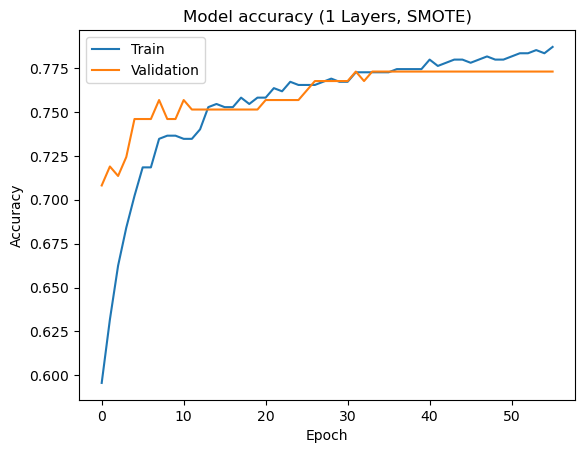

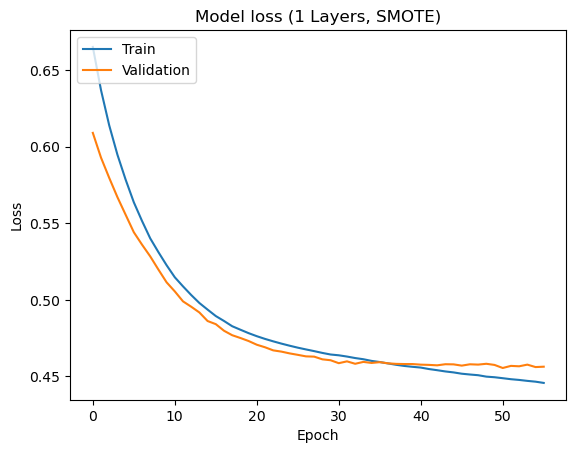

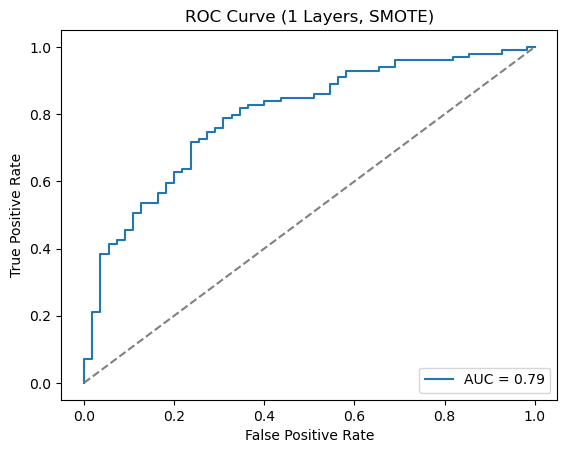

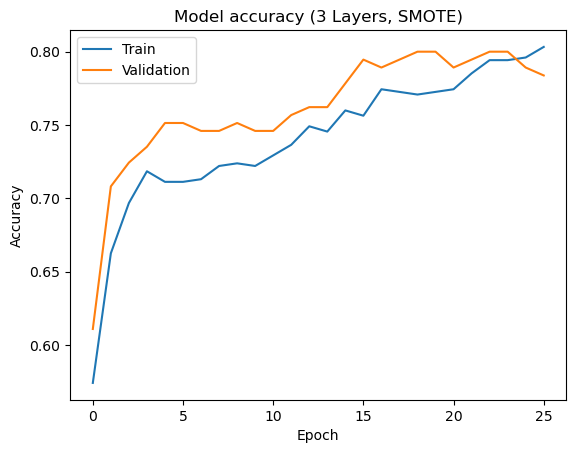

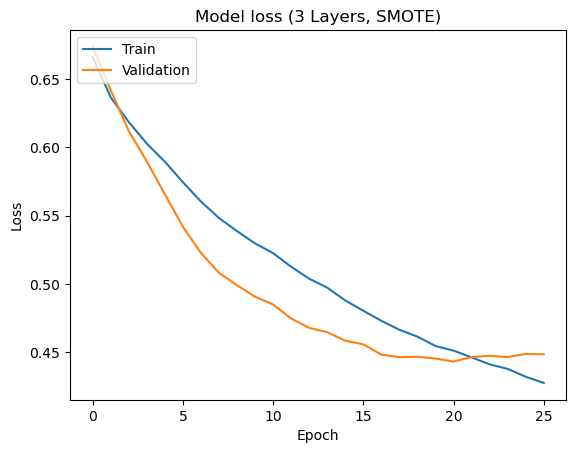

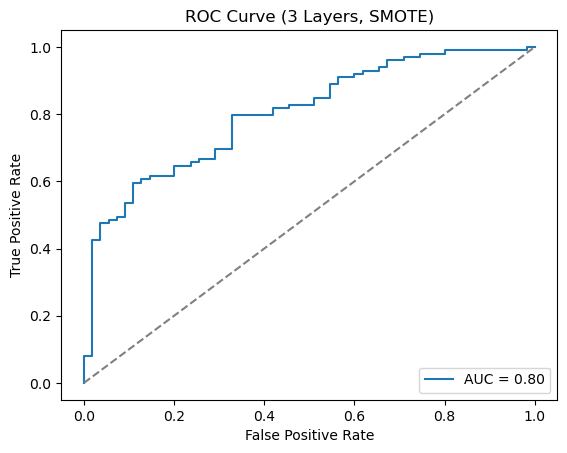

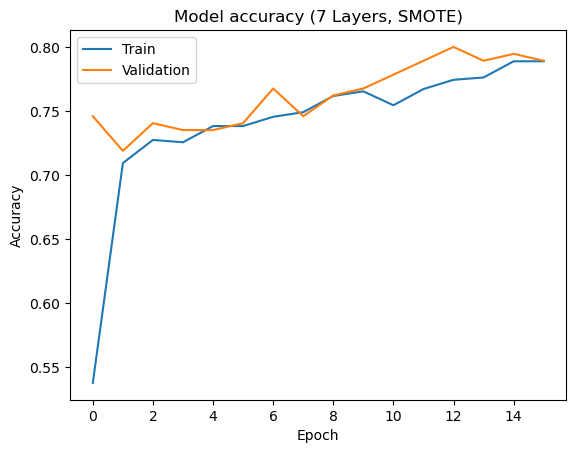

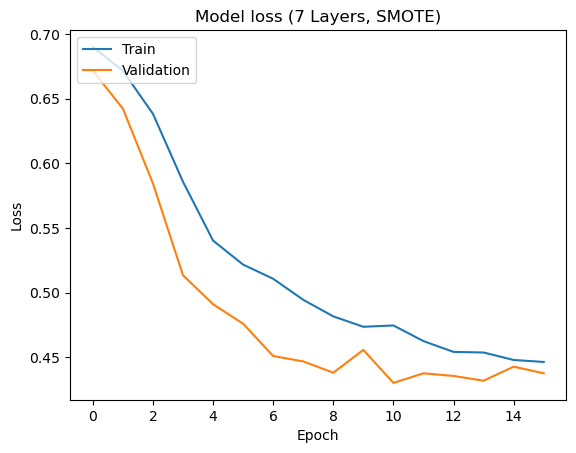

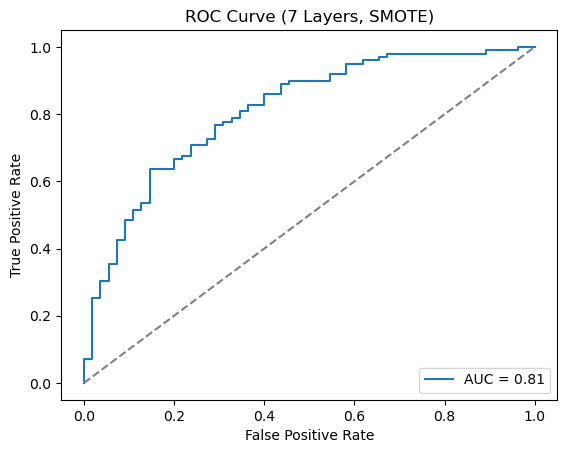

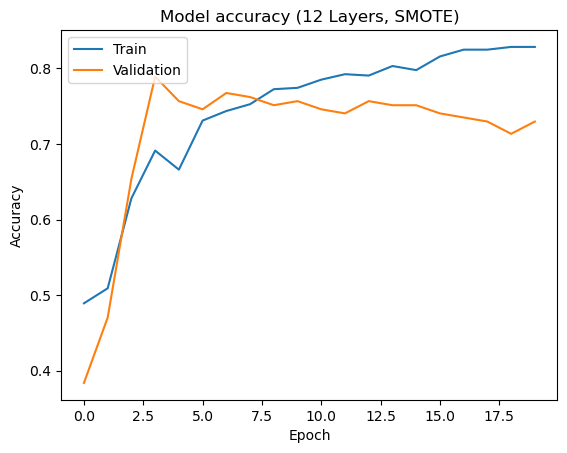

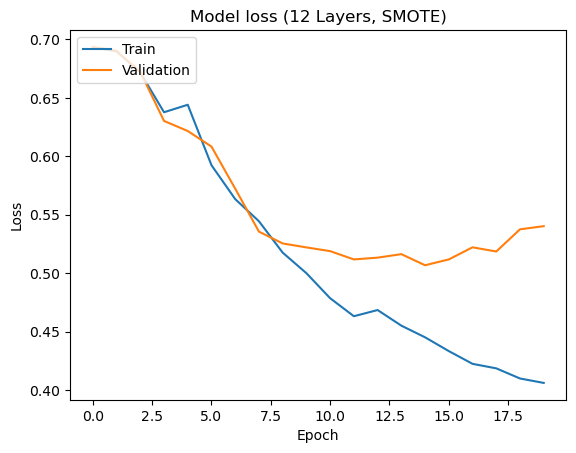

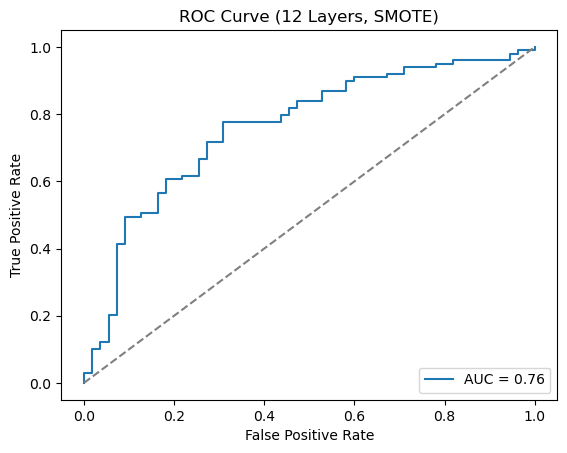

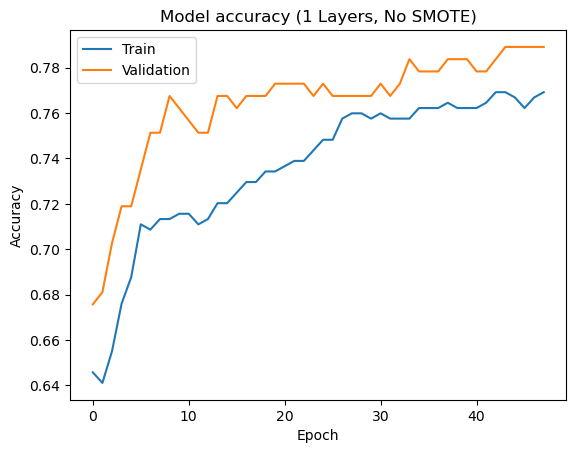

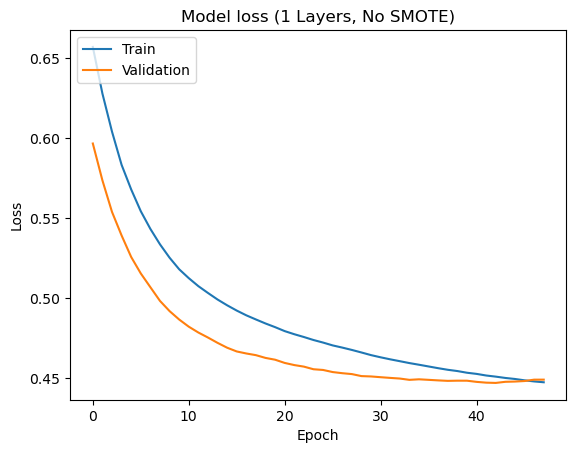

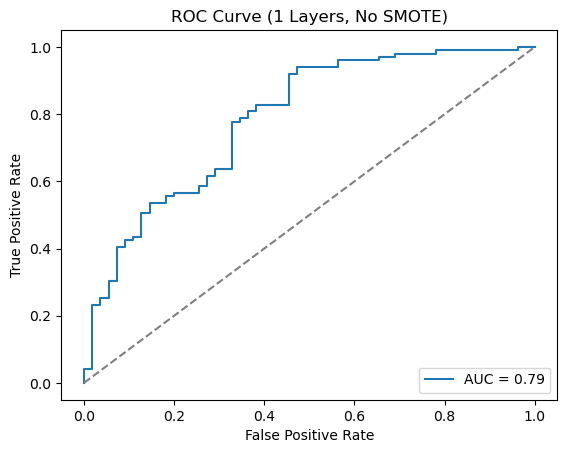

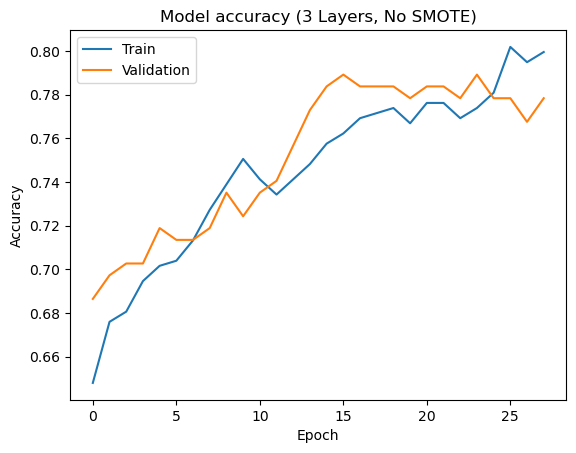

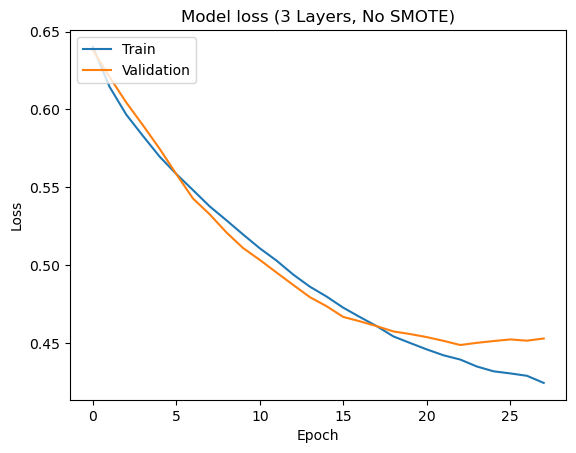

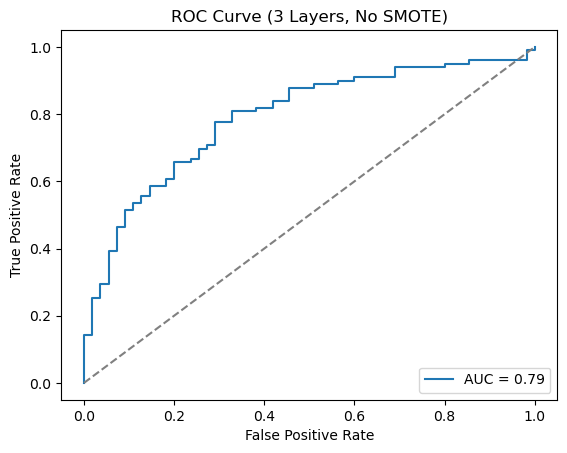

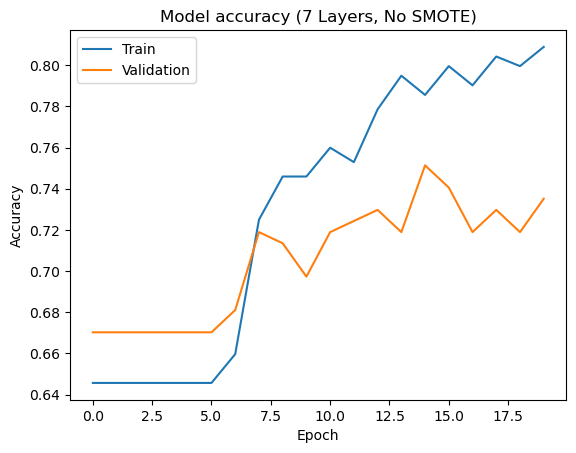

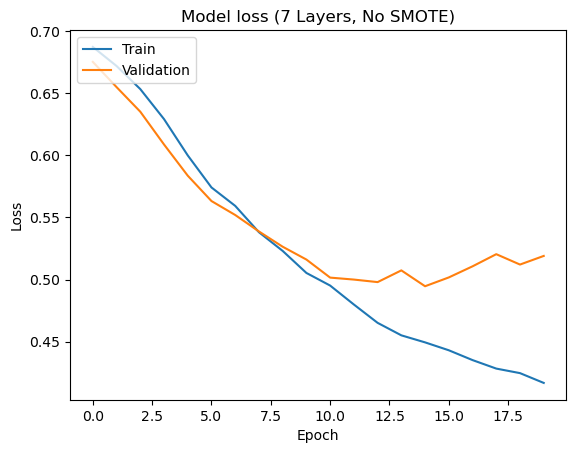

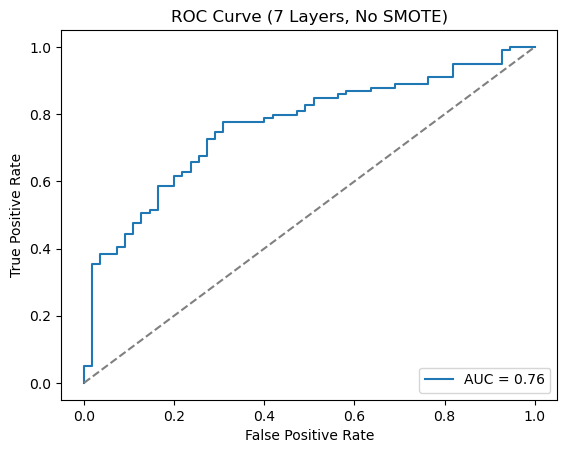

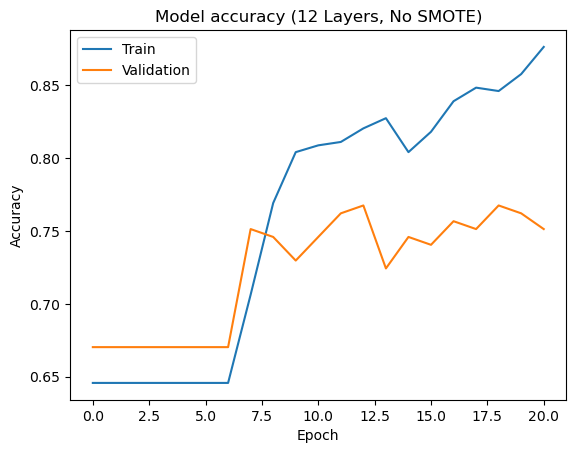

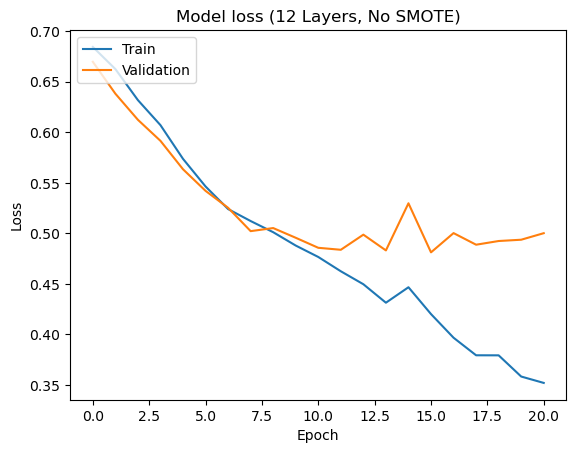

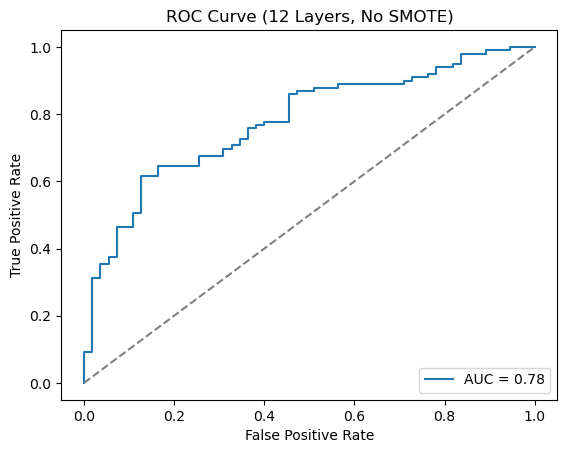

In [122]:
# define function to plot training history
def plot_training_history(history, num_layers, smote_status):
    # plot training & validation accuracy values
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy ({num_layers} Layers, {smote_status})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss ({num_layers} Layers, {smote_status})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# updated ROC curve plot function with correct parameter
def plot_roc_curve(y_test, y_pred_proba, num_layers, smote_status):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.title(f'ROC Curve ({num_layers} Layers, {smote_status})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



# plot the training history for each model
for (layers, smote_status), result in results.items():
    plot_training_history(result['history'], layers, smote_status)
    plot_roc_curve(Y_Test, result['y_pred_proba'], layers, smote_status)